In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit

Add image here

# Data Loading Tools

Steps 1 and 2

Lulu: make_time_windows and make_x_y is similar to Aisha's data_label_split and data_divide. Differences:
* make_x_y requires a single column to be selected and builds y's from it
* make_time_windows fixes the sequence length and drags the window down each participant's timeseries (not the concatenated npy with all visits)

To do:
* Normalisation/Scaling

In [2]:
def load_DoppelGANger():
  ori_data = np.load('ori_features_prism.npy')
  gen_data = np.load('features_600.npy')
  return ori_data, gen_data # both have np.shape = (1347 participants, 130 visits, 5 features)


def make_time_windows(dataset, w):
  """replaces each participant's 130 long timeseries with all their w length window timeseries
  """
  num_participants, full_length, _ = np.shape(dataset)
  time_windows = []

  for i in list(range(num_participants)): # i = participant's position in dataset

    for j in list(range(full_length-w+1)): # j = row number of first row in window
      time_windows.append(dataset[i,j:j+w,:])

  return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
  """make inputs for model. Note input sequence length = w-1
  """
  dataset = make_time_windows(dataset, w)
  x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
  x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
  y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
  return x, y

Shape Checks:

In [3]:
ori_set, gen_set = load_DoppelGANger()
print([np.shape(_set) for _set in [ori_set, gen_set]])

x, y = make_x_y(ori_set, 0, 129)
print([np.shape(_set) for _set in [x, y]])
print([type(_set) for _set in [x, y]])

[(1347, 130, 5), (1347, 130, 5)]
[(2694, 128, 4), (2694, 128, 1)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


# Define Predictive Model

Lulu: moved import statements out of functions and to the top of the document

In [4]:
def last_time_step_mae(Y_true, Y_pred):
  return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
  input_size = [None,num_cols-1] #
  hidden_dim = num_cols//2 #

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # shape = [#timesteps -1, #features=dim-1] per 
  model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # output shape = [#timesteps -1, 1]

  model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

  return model

# Define Evaluation Scheme

Lulu to do: 
* change args to list//tuple//dict type for easier looping through sets of prameters
* is loss working right? seems proportional to window length. Must normalise beforehand?

In [5]:
def predictive_train_test(train_set, test_set, y_cols='all', windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
  """ does the T_T_ portion of the scheme

  Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off)
      Make sure train and test are disjoint!
      If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - windows: list contains lengths of windows to be used in order of y columns
              NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

  Returns:
   - results:
   """



  results = []
  histories = []
  _, max_window, num_columns = np.shape(train_set)
  
  #### for convenience when not tuning parameters
  if y_cols=='all':
    y_cols = list(range(num_columns))

  if windows=='max':
    windows=[max_window]*len(y_cols)
  elif isinstance(windows, int):
      windows=[windows]*len(y_cols)

  for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
    print('\nPredictive model running for column ', str(y_cols[k]), ' with window length ', str(windows[k]))
    train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
    test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

    model = make_predictive_model(num_columns)
    hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) # step 4
    print('Getting results for column ', str(y_cols[k]), ' with window length ', str(windows[k]))

    results.append([y_cols[k], windows[k], batch_size, epochs]+model.evaluate(test_x, test_y, batch_size=batch_size))
    histories.append(hist)

    if show_training:
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train loss', 'val loss'], loc='upper right')
      plt.show()

  results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'batch_size', 'epochs', 'test_loss', 'test_metric'])

  return results_df, histories

# TRTS Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 6.8180 - last_time_step_mae: 0.9633 - val_loss: 6.7749 - val_last_time_step_mae: 0.9289
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.7064 - last_time_step_mae: 0.8817 - val_loss: 6.7009 - val_last_time_step_mae: 0.9161
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.6189 - last_time_step_mae: 0.8675 - val_loss: 6.5981 - val_last_time_step_mae: 0.8995
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.5017 - last_time_step_mae: 0.8489 - val_loss: 6.4634 - val_last_time_step_mae: 0.8779
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.3578 - last_time_step_mae: 0.8266 - val_loss: 6.3084 - val_last_time_step_mae: 0.8534
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.1119 - last_time_step_mae: 0.7878 - va

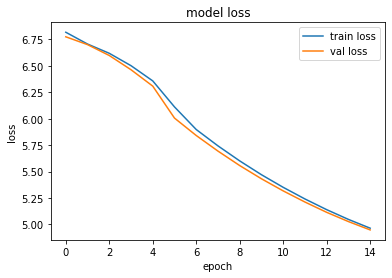


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 5.1863 - last_time_step_mae: 0.8217 - val_loss: 5.1428 - val_last_time_step_mae: 0.8319
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.0057 - last_time_step_mae: 0.7735 - val_loss: 4.9603 - val_last_time_step_mae: 0.8004
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.8083 - last_time_step_mae: 0.7420 - val_loss: 4.7470 - val_last_time_step_mae: 0.7647
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.5836 - last_time_step_mae: 0.7059 - val_loss: 4.5122 - val_last_time_step_mae: 0.7251
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.3447 - last_time_step_mae: 0.6674 - val_loss: 4.2690 - val_last_time_step_mae: 0.6831
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 4.1027 - last_time_step_mae: 0.6286 - va

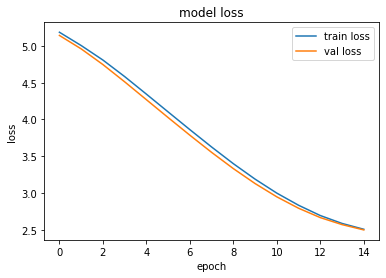


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 24.0706 - last_time_step_mae: 4.0825 - val_loss: 24.2070 - val_last_time_step_mae: 4.1015
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.9522 - last_time_step_mae: 4.0094 - val_loss: 24.1212 - val_last_time_step_mae: 4.0873
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.8389 - last_time_step_mae: 3.9912 - val_loss: 23.9846 - val_last_time_step_mae: 4.0649
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.6840 - last_time_step_mae: 3.9659 - val_loss: 23.8100 - val_last_time_step_mae: 4.0359
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.4925 - last_time_step_mae: 3.9348 - val_loss: 23.6022 - val_last_time_step_mae: 4.0021
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.2739 - last_time_step_mae: 

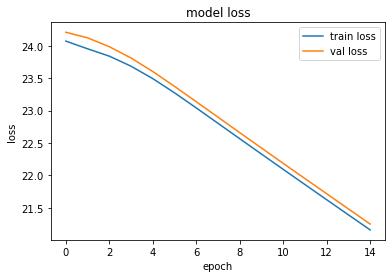


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.6210 - last_time_step_mae: 0.3913 - val_loss: 2.5131 - val_last_time_step_mae: 0.3250
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.4808 - last_time_step_mae: 0.3555 - val_loss: 2.3754 - val_last_time_step_mae: 0.3043
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.3294 - last_time_step_mae: 0.3303 - val_loss: 2.2267 - val_last_time_step_mae: 0.2819
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.1740 - last_time_step_mae: 0.3036 - val_loss: 2.0740 - val_last_time_step_mae: 0.2569
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 2.0204 - last_time_step_mae: 0.2744 - val_loss: 1.9324 - val_last_time_step_mae: 0.2311
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 1.8890 - last_time_step_mae: 0.2465 - va

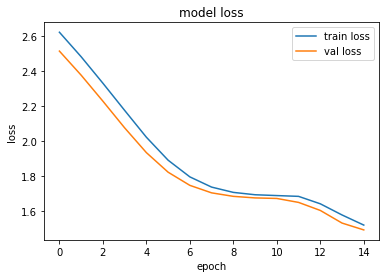


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.2473 - last_time_step_mae: 1.2277 - val_loss: 7.2891 - val_last_time_step_mae: 1.2345
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.1226 - last_time_step_mae: 1.1718 - val_loss: 7.1766 - val_last_time_step_mae: 1.2160
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9925 - last_time_step_mae: 1.1508 - val_loss: 7.0265 - val_last_time_step_mae: 1.1915
Epoch 4/15
1112/1112 [==============================] - 6s 6ms/step - loss: 6.8265 - last_time_step_mae: 1.1240 - val_loss: 6.8394 - val_last_time_step_mae: 1.1608
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.6259 - last_time_step_mae: 1.0910 - val_loss: 6.6211 - val_last_time_step_mae: 1.1248
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.4021 - last_time_step_mae: 1.0545 - va

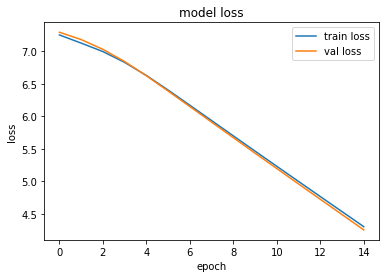

In [6]:
TRTS_results, TRTS_histories = predictive_train_test(ori_set, gen_set, windows=[65,65,65,65,65])

In [8]:
TRTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,6.726365,1.083900
1,1,65,64,15,4.044926,0.509953
2,2,65,64,15,20.597420,2.934123
3,3,65,64,15,1.434082,0.178937
4,4,65,64,15,4.037988,0.608182


In [18]:
TRTS_results.to_csv('dp_predictive_trts_results.csv', index=False)

# TSTR Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 7.9275 - last_time_step_mae: 1.3213 - val_loss: 7.7680 - val_last_time_step_mae: 1.2843
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.7561 - last_time_step_mae: 1.2350 - val_loss: 7.6263 - val_last_time_step_mae: 1.2634
Epoch 3/15
1112/1112 [==============================] - 7s 7ms/step - loss: 7.5954 - last_time_step_mae: 1.2104 - val_loss: 7.4578 - val_last_time_step_mae: 1.2373
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.4194 - last_time_step_mae: 1.1828 - val_loss: 7.2855 - val_last_time_step_mae: 1.2108
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.2456 - last_time_step_mae: 1.1564 - val_loss: 7.1209 - val_last_time_step_mae: 1.1851
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.0835 - last_time_step_mae: 1.1308 - va

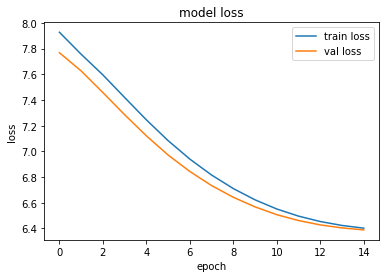


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 7ms/step - loss: 6.3096 - last_time_step_mae: 0.8332 - val_loss: 6.2755 - val_last_time_step_mae: 0.8600
Epoch 2/15
1112/1112 [==============================] - 7s 7ms/step - loss: 6.1712 - last_time_step_mae: 0.8031 - val_loss: 6.1252 - val_last_time_step_mae: 0.8393
Epoch 3/15
1112/1112 [==============================] - 8s 7ms/step - loss: 6.0043 - last_time_step_mae: 0.7789 - val_loss: 5.9528 - val_last_time_step_mae: 0.8147
Epoch 4/15
1112/1112 [==============================] - 7s 7ms/step - loss: 5.8209 - last_time_step_mae: 0.7522 - val_loss: 5.7563 - val_last_time_step_mae: 0.7861
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.6155 - last_time_step_mae: 0.7222 - val_loss: 5.5424 - val_last_time_step_mae: 0.7561
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 5.4053 - last_time_step_mae: 0.6919 - va

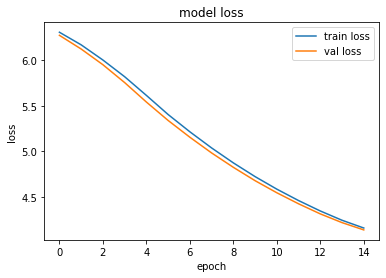


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.4587 - last_time_step_mae: 3.3648 - val_loss: 22.9405 - val_last_time_step_mae: 3.3463
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.3537 - last_time_step_mae: 3.3240 - val_loss: 22.8267 - val_last_time_step_mae: 3.3290
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.2107 - last_time_step_mae: 3.3034 - val_loss: 22.6625 - val_last_time_step_mae: 3.3043
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 23.0255 - last_time_step_mae: 3.2765 - val_loss: 22.4633 - val_last_time_step_mae: 3.2744
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 22.8136 - last_time_step_mae: 3.2458 - val_loss: 22.2460 - val_last_time_step_mae: 3.2417
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 22.5895 - last_time_step_mae: 

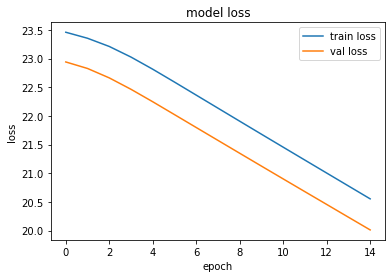


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 8s 7ms/step - loss: 2.0730 - last_time_step_mae: 0.2925 - val_loss: 2.0870 - val_last_time_step_mae: 0.2636
Epoch 2/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.9502 - last_time_step_mae: 0.2421 - val_loss: 1.9570 - val_last_time_step_mae: 0.2458
Epoch 3/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.8232 - last_time_step_mae: 0.2236 - val_loss: 1.8300 - val_last_time_step_mae: 0.2297
Epoch 4/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.7028 - last_time_step_mae: 0.2067 - val_loss: 1.7124 - val_last_time_step_mae: 0.2136
Epoch 5/15
1112/1112 [==============================] - 7s 7ms/step - loss: 1.5996 - last_time_step_mae: 0.1914 - val_loss: 1.6193 - val_last_time_step_mae: 0.2024
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 1.5172 - last_time_step_mae: 0.1809 - va

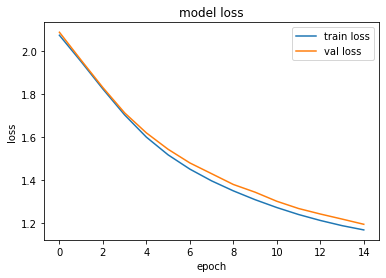


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 7s 6ms/step - loss: 7.1488 - last_time_step_mae: 1.1634 - val_loss: 6.8464 - val_last_time_step_mae: 1.0479
Epoch 2/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9838 - last_time_step_mae: 1.0297 - val_loss: 6.8029 - val_last_time_step_mae: 1.0413
Epoch 3/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9420 - last_time_step_mae: 1.0239 - val_loss: 6.7634 - val_last_time_step_mae: 1.0351
Epoch 4/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.9024 - last_time_step_mae: 1.0182 - val_loss: 6.7259 - val_last_time_step_mae: 1.0301
Epoch 5/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.8637 - last_time_step_mae: 1.0125 - val_loss: 6.6884 - val_last_time_step_mae: 1.0245
Epoch 6/15
1112/1112 [==============================] - 7s 6ms/step - loss: 6.8251 - last_time_step_mae: 1.0069 - va

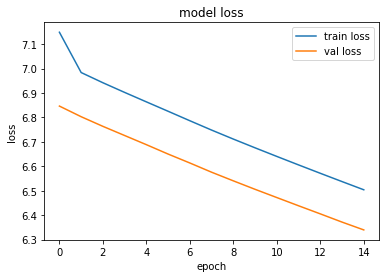

In [13]:
TSTR_results, TSTR_histories = predictive_train_test(gen_set, ori_set, windows=[65,65,65,65,65])

In [16]:
TSTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,4.548269,0.580051
1,1,65,64,15,2.580028,0.356853
2,2,65,64,15,20.981253,3.535945
3,3,65,64,15,1.542471,0.203011
4,4,65,64,15,6.689484,1.108748


In [19]:
TSTR_results.to_csv('dp_predictive_tstr_results.csv', index=False)

# TRTR vs TSTS Example


Predictive model running for column  0  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 6.7584 - last_time_step_mae: 0.8526 - val_loss: 6.7656 - val_last_time_step_mae: 0.9445
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 6.7187 - last_time_step_mae: 0.8461 - val_loss: 6.7170 - val_last_time_step_mae: 0.9360
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 6.6646 - last_time_step_mae: 0.8372 - val_loss: 6.6567 - val_last_time_step_mae: 0.9262
Epoch 4/20
556/556 [==============================] - 3s 6ms/step - loss: 6.6000 - last_time_step_mae: 0.8268 - val_loss: 6.5895 - val_last_time_step_mae: 0.9159
Epoch 5/20
556/556 [==============================] - 3s 6ms/step - loss: 6.5291 - last_time_step_mae: 0.8156 - val_loss: 6.5132 - val_last_time_step_mae: 0.9031
Epoch 6/20
556/556 [==============================] - 3s 6ms/step - loss: 6.4483 - last_time_step_mae: 0.8029 - val_loss: 6.42

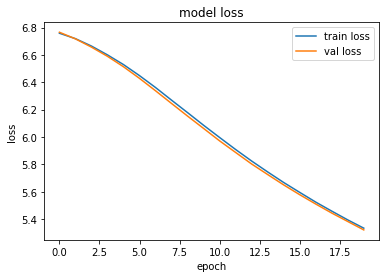


Predictive model running for column  1  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 4.9294 - last_time_step_mae: 0.7165 - val_loss: 4.9001 - val_last_time_step_mae: 0.7220
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 4.8249 - last_time_step_mae: 0.6954 - val_loss: 4.7967 - val_last_time_step_mae: 0.7042
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 4.7245 - last_time_step_mae: 0.6794 - val_loss: 4.6950 - val_last_time_step_mae: 0.6873
Epoch 4/20
556/556 [==============================] - 3s 6ms/step - loss: 4.6222 - last_time_step_mae: 0.6628 - val_loss: 4.5887 - val_last_time_step_mae: 0.6696
Epoch 5/20
556/556 [==============================] - 3s 6ms/step - loss: 4.5146 - last_time_step_mae: 0.6455 - val_loss: 4.4768 - val_last_time_step_mae: 0.6507
Epoch 6/20
556/556 [==============================] - 3s 6ms/step - loss: 4.4020 - last_time_step_mae: 0.6273 - val_loss: 4.36

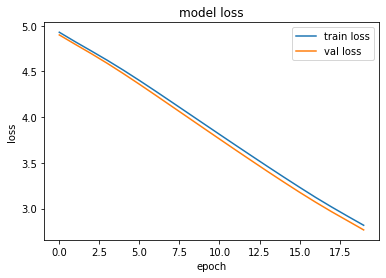


Predictive model running for column  2  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 23.2860 - last_time_step_mae: 3.9863 - val_loss: 23.9968 - val_last_time_step_mae: 3.9929
Epoch 2/20
556/556 [==============================] - 4s 6ms/step - loss: 22.9903 - last_time_step_mae: 3.7615 - val_loss: 23.8009 - val_last_time_step_mae: 3.9608
Epoch 3/20
556/556 [==============================] - 4s 6ms/step - loss: 22.7850 - last_time_step_mae: 3.7289 - val_loss: 23.5753 - val_last_time_step_mae: 3.9244
Epoch 4/20
556/556 [==============================] - 4s 6ms/step - loss: 22.5629 - last_time_step_mae: 3.6925 - val_loss: 23.3416 - val_last_time_step_mae: 3.8861
Epoch 5/20
556/556 [==============================] - 4s 7ms/step - loss: 22.3384 - last_time_step_mae: 3.6562 - val_loss: 23.1090 - val_last_time_step_mae: 3.8483
Epoch 6/20
556/556 [==============================] - 4s 6ms/step - loss: 22.1163 - last_time_step_mae: 3.6201 - val

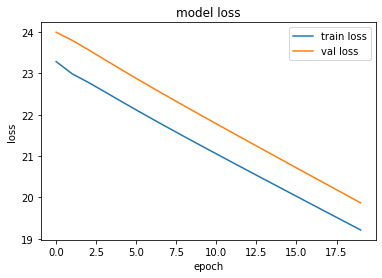


Predictive model running for column  3  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 2.4210 - last_time_step_mae: 0.3183 - val_loss: 2.2319 - val_last_time_step_mae: 0.2860
Epoch 2/20
556/556 [==============================] - 4s 7ms/step - loss: 2.3115 - last_time_step_mae: 0.2915 - val_loss: 2.1012 - val_last_time_step_mae: 0.2654
Epoch 3/20
556/556 [==============================] - 4s 6ms/step - loss: 2.2212 - last_time_step_mae: 0.2772 - val_loss: 2.0325 - val_last_time_step_mae: 0.2537
Epoch 4/20
556/556 [==============================] - 4s 7ms/step - loss: 2.1503 - last_time_step_mae: 0.2655 - val_loss: 1.9647 - val_last_time_step_mae: 0.2428
Epoch 5/20
556/556 [==============================] - 4s 7ms/step - loss: 2.0780 - last_time_step_mae: 0.2535 - val_loss: 1.8965 - val_last_time_step_mae: 0.2337
Epoch 6/20
556/556 [==============================] - 4s 6ms/step - loss: 2.0040 - last_time_step_mae: 0.2406 - val_loss: 1.82

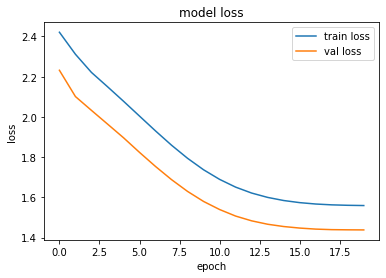


Predictive model running for column  4  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 7.2133 - last_time_step_mae: 1.1996 - val_loss: 7.1518 - val_last_time_step_mae: 1.1446
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 7.1928 - last_time_step_mae: 1.1882 - val_loss: 7.1390 - val_last_time_step_mae: 1.1427
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 7.1786 - last_time_step_mae: 1.1859 - val_loss: 7.1240 - val_last_time_step_mae: 1.1402
Epoch 4/20
556/556 [==============================] - 3s 6ms/step - loss: 7.1629 - last_time_step_mae: 1.1834 - val_loss: 7.1084 - val_last_time_step_mae: 1.1383
Epoch 5/20
556/556 [==============================] - 3s 6ms/step - loss: 7.1464 - last_time_step_mae: 1.1808 - val_loss: 7.0912 - val_last_time_step_mae: 1.1352
Epoch 6/20
556/556 [==============================] - 3s 6ms/step - loss: 7.1293 - last_time_step_mae: 1.1780 - val_loss: 7.07

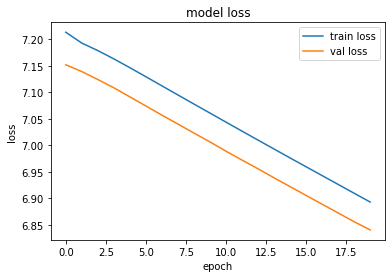


Predictive model running for column  0  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 8.5643 - last_time_step_mae: 1.6273 - val_loss: 8.2067 - val_last_time_step_mae: 1.3645
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 8.4599 - last_time_step_mae: 1.5223 - val_loss: 8.1964 - val_last_time_step_mae: 1.3627
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 8.4510 - last_time_step_mae: 1.5210 - val_loss: 8.1880 - val_last_time_step_mae: 1.3609
Epoch 4/20
556/556 [==============================] - 3s 6ms/step - loss: 8.4431 - last_time_step_mae: 1.5198 - val_loss: 8.1805 - val_last_time_step_mae: 1.3597
Epoch 5/20
556/556 [==============================] - 3s 6ms/step - loss: 8.4354 - last_time_step_mae: 1.5186 - val_loss: 8.1731 - val_last_time_step_mae: 1.3591
Epoch 6/20
556/556 [==============================] - 3s 6ms/step - loss: 8.4272 - last_time_step_mae: 1.5174 - val_loss: 8.16

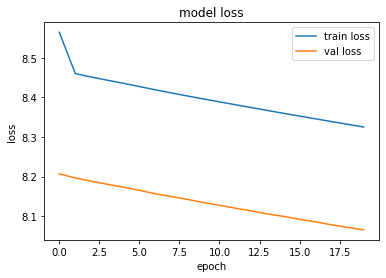


Predictive model running for column  1  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 6.6877 - last_time_step_mae: 1.0009 - val_loss: 6.5109 - val_last_time_step_mae: 0.9231
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 6.6059 - last_time_step_mae: 0.9390 - val_loss: 6.4769 - val_last_time_step_mae: 0.9183
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 6.5600 - last_time_step_mae: 0.9324 - val_loss: 6.4194 - val_last_time_step_mae: 0.9101
Epoch 4/20
556/556 [==============================] - 3s 6ms/step - loss: 6.4945 - last_time_step_mae: 0.9230 - val_loss: 6.3474 - val_last_time_step_mae: 0.8998
Epoch 5/20
556/556 [==============================] - 3s 6ms/step - loss: 6.4164 - last_time_step_mae: 0.9120 - val_loss: 6.2633 - val_last_time_step_mae: 0.8872
Epoch 6/20
556/556 [==============================] - 3s 6ms/step - loss: 6.3267 - last_time_step_mae: 0.8990 - val_loss: 6.16

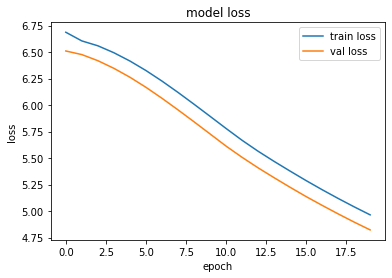


Predictive model running for column  2  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 24.2122 - last_time_step_mae: 3.6461 - val_loss: 22.9529 - val_last_time_step_mae: 3.4518
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 23.9269 - last_time_step_mae: 3.4533 - val_loss: 22.7699 - val_last_time_step_mae: 3.4250
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 23.7148 - last_time_step_mae: 3.4221 - val_loss: 22.5529 - val_last_time_step_mae: 3.3929
Epoch 4/20
556/556 [==============================] - 3s 6ms/step - loss: 23.4797 - last_time_step_mae: 3.3887 - val_loss: 22.3235 - val_last_time_step_mae: 3.3588
Epoch 5/20
556/556 [==============================] - 4s 6ms/step - loss: 23.2402 - last_time_step_mae: 3.3533 - val_loss: 22.0954 - val_last_time_step_mae: 3.3250
Epoch 6/20
556/556 [==============================] - 3s 6ms/step - loss: 23.0038 - last_time_step_mae: 3.3192 - val

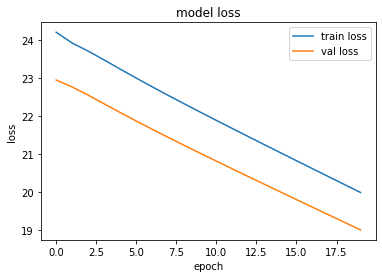


Predictive model running for column  3  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 2.0706 - last_time_step_mae: 0.3070 - val_loss: 2.0065 - val_last_time_step_mae: 0.3073
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 1.9806 - last_time_step_mae: 0.2543 - val_loss: 1.9471 - val_last_time_step_mae: 0.2965
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 1.9243 - last_time_step_mae: 0.2461 - val_loss: 1.8923 - val_last_time_step_mae: 0.2873
Epoch 4/20
556/556 [==============================] - 4s 6ms/step - loss: 1.8702 - last_time_step_mae: 0.2384 - val_loss: 1.8375 - val_last_time_step_mae: 0.2784
Epoch 5/20
556/556 [==============================] - 4s 7ms/step - loss: 1.8172 - last_time_step_mae: 0.2311 - val_loss: 1.7862 - val_last_time_step_mae: 0.2697
Epoch 6/20
556/556 [==============================] - 4s 7ms/step - loss: 1.7700 - last_time_step_mae: 0.2245 - val_loss: 1.74

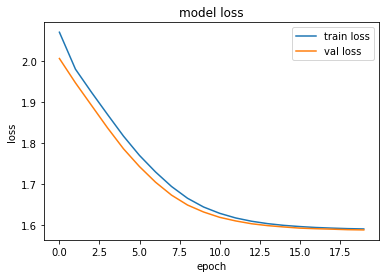


Predictive model running for column  4  with window length  65
Epoch 1/20
556/556 [==============================] - 4s 7ms/step - loss: 7.1400 - last_time_step_mae: 1.0843 - val_loss: 6.9050 - val_last_time_step_mae: 1.0113
Epoch 2/20
556/556 [==============================] - 3s 6ms/step - loss: 7.0155 - last_time_step_mae: 1.0441 - val_loss: 6.8088 - val_last_time_step_mae: 0.9981
Epoch 3/20
556/556 [==============================] - 3s 6ms/step - loss: 6.9171 - last_time_step_mae: 1.0300 - val_loss: 6.7106 - val_last_time_step_mae: 0.9848
Epoch 4/20
556/556 [==============================] - 4s 6ms/step - loss: 6.8138 - last_time_step_mae: 1.0152 - val_loss: 6.6088 - val_last_time_step_mae: 0.9700
Epoch 5/20
556/556 [==============================] - 4s 7ms/step - loss: 6.7070 - last_time_step_mae: 0.9994 - val_loss: 6.5012 - val_last_time_step_mae: 0.9541
Epoch 6/20
556/556 [==============================] - 4s 7ms/step - loss: 6.5950 - last_time_step_mae: 0.9831 - val_loss: 6.38

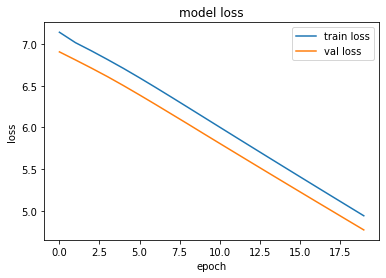

In [26]:
train_ori_set, test_ori_set = train_test_split(ori_set, train_size=0.5)
TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, windows=65, epochs=20)

train_gen_set, test_gen_set = train_test_split(gen_set, train_size=0.5)
TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, windows=65, epochs=20)

In [27]:
TRTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,20,5.357162,0.711760
1,1,65,64,20,3.354212,0.558199
2,2,65,64,20,20.354578,3.518324
3,3,65,64,20,1.838769,0.246920
4,4,65,64,20,6.998713,1.168536


In [28]:
TRTR_results.to_csv('dp_predictive_trtr_results2.csv', index=False)

In [29]:
TSTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,20,7.385734,1.044242
1,1,65,64,20,4.519409,0.513693
2,2,65,64,20,18.541113,2.581589
3,3,65,64,20,1.559514,0.181012
4,4,65,64,20,4.623684,0.694531


In [31]:
TSTS_results.to_csv('dp_predictive_tsts_results2.csv', index=False)

### Comparing TRTR vs TSTS results

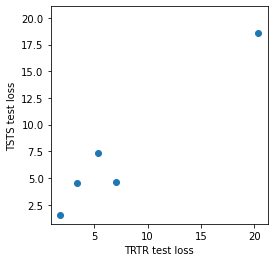

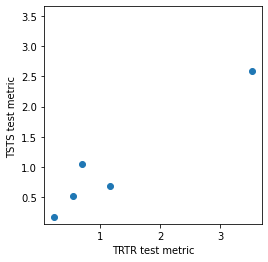

In [32]:
plt.scatter(TRTR_results['test_loss'], TSTS_results['test_loss'])
plt.xlabel('TRTR test loss')
plt.ylabel('TSTS test loss')
plt.axis('square')
plt.show()

plt.scatter(TRTR_results['test_metric'], TSTS_results['test_metric'])
plt.xlabel('TRTR test metric')
plt.ylabel('TSTS test metric ')
plt.axis('square')
plt.show()

### SRA